In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf 6864-hw1

In [ ]:
import os
os.makedirs("6864-hw1", exist_ok=True)
import sys
sys.path.append("/content/6864-hw1")

In [ ]:
!pip install sacrebleu

# **Part 0: Data Loading and Preprocessing**

In this section we will load the data that we will be using throughout the lab and perform some preprocessing steps. You do not need to write any code for this part, but you are encouraged to read through the code carefully and make sure you understand it. After Part 1, we will provide some additional scaffolding specific to the RNN-based parts of the lab.

First we download the data. The dataset consists of parallel English and Vietnamese sentences (IWSLT'15 English-Vietnamese translation data). In the first two parts of the lab, you will do language modeling using only the English data, and in the final part of the lab you will do translation from Vietnamese to English.

In [ ]:
# Download data
!wget -nv -O /content/6864-hw1/train.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget -nv -O /content/6864-hw1/train.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget -nv -O /content/6864-hw1/tst2013.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget -nv -O /content/6864-hw1/tst2013.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi
!wget -nv -O /content/6864-hw1/vocab.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
!wget -nv -O /content/6864-hw1/vocab.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi

Next we read and store the data.

In [ ]:
def read_sentence_file(filename):
  sentences_list = []
  with open(filename, "r") as f:
    for line in f:
      sentences_list.append(line.strip().split())
  return sentences_list

def read_vocab_file(filename):
  with open(filename, "r") as f:
    return [line.strip() for line in f]


src_vocab_set = read_vocab_file(os.path.join("/content/6864-hw1", "vocab.vi"))
trg_vocab_set = read_vocab_file(os.path.join("/content/6864-hw1", "vocab.en"))

train_src_sentences_list = read_sentence_file(os.path.join("/content/6864-hw1",
                                                           "train.vi"))
train_trg_sentences_list = read_sentence_file(os.path.join("/content/6864-hw1",
                                                           "train.en"))
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

test_src_sentences_list = read_sentence_file(os.path.join("/content/6864-hw1",
                                                          "tst2013.vi"))
test_trg_sentences_list = read_sentence_file(os.path.join("/content/6864-hw1",
                                                          "tst2013.en"))
assert len(test_src_sentences_list) == len(test_trg_sentences_list)

Next we do preprocessing on the dataset, and we perform a preliminary data analysis.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


MAX_SENT_LENGTH = 48
MAX_SENT_LENGTH_PLUS_SOS_EOS = 50

# We only keep sentences that do not exceed 48 words, so that later when we
# add <s> and </s> to a sentence it still won't exceed 50 words.
def filter_data(src_sentences_list, trg_sentences_list, max_len):
  new_src_sentences_list, new_trg_sentences_list = [], []
  for src_sent, trg_sent in zip(src_sentences_list, trg_sentences_list):
    if (len(src_sent) <= max_len and len(trg_sent) <= max_len
        and len(src_sent) > 0 and len(trg_sent)) > 0:
      new_src_sentences_list.append(src_sent)
      new_trg_sentences_list.append(trg_sent)
  return new_src_sentences_list, new_trg_sentences_list

train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, train_trg_sentences_list, max_len=MAX_SENT_LENGTH)
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, test_trg_sentences_list, max_len=MAX_SENT_LENGTH)

# We take 10% of the training data to be the validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

# Show some data stats
print("Number of training (src, trg) sentence pairs: %d" %
      len(train_src_sentences_list))
print("Number of validation (src, trg) sentence pairs: %d" %
      len(val_src_sentences_list))
print("Number of testing (src, trg) sentence pairs: %d" %
      len(test_src_sentences_list))
src_vocab_set = ['<pad>'] + src_vocab_set
trg_vocab_set = ['<pad>'] + trg_vocab_set
print("Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(src_vocab_set))
print("Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(trg_vocab_set))

length = [len(sent) for sent in train_src_sentences_list]
print('Training sentence avg. length: %d ' % np.mean(length))
print('Training sentence length at 95-percentile: %d' %
      np.percentile(length, 95))
print('Training sentence length distribution '
      '(x-axis is length range and y-axis is count):\n')
plt.hist(length, bins=5)
plt.show()

print('Example Vietnamese input: ' + str(train_src_sentences_list[0]))
print('Its target English output: ' + str(train_trg_sentences_list[0]))

# **Part 1: Count Based Language Model**
In this part, you will implement a basic counts based language model, as discussed in class. Language Models assign probabilities to sequence of words. The basic intuition of the model we will implement is that instead of computing the probability of a word given its entire context, we can look just at the last few words.

The first two pieces are functions that create a frequency dictionary of counts and generate ngrams.

In [ ]:
import re
def freq_dict(data,n):
    '''
    Input:
    data: list of strings
    n: integer that determines length of sequences
    
    Return: 
    dictionary that maps a sequence to the number of times the seequence occurs in the corpus
    
    '''

    data = [i.lower() for i in data]
    data = [re.sub(r'[^\w\s]', '', i) for i in data]
    ### Your code here!

In [ ]:
def generate_ngrams(data, n):
    '''
    Input:
    data: string
    n: integer that determines length of sequences
    
    Return: 
    list of all possible n length ngrams
    '''
    data = data.lower()
    data = re.sub(r'[^\w\s]', '', data)
    ### Your code here!

In [ ]:
#TEST
sentences = ["I love cats and hate dogs because dogs smell bad.","Dogs are too messy but cats are clean."]
print(freq_dict(sentences,1))
print(generate_ngrams(sentences[0],3))

In [ ]:
import random
import math

def tokenize(data):
    return re.findall(r"[\w]+|[^\s\w]", data)

def ngrams(n, tokens):
  """
  Input: tokens and length of n-gram

  Calculates ngrams"""
  pad = ["<s>"]*(n-1) + tokens + ["</s>"]
  nlist=[]
  #for i, token in enumerate(pad):
        ### Your code here!
    

class CountModel(object):

    def __init__(self, n):
        self.n = n
        #Dictionary mapping context ngrams to a dictionary that maps words following the key ngram to the number of times they appear
        #Example: If we look at the sentence "I have a dog", then prevword_dic = { "I have" : {"a": 1, "dog": 1}, {"have a" : {"dog": 1} } }
        self.prevword_dic = {}
        # maps context ngrams to number of times it appears in data
        # Example: for n=3: {"i have a":3}
        self.prevcount_dic = {}
        

    def add(self, sentence):
      """
    Input: Sentence

    Adds new data to model's dicts and counts
    Returns nothing
    """
      tok=tokenize(sentence)
      ngrams_=ngrams(self.n, tok)
      # Goal is to take ngrams and update prevword_dic and prevcount_dic
      ### Your code here!
      return


    def prob(self, context, token):
      """
    Input: Previous words and current word

    Calculates probability of each word occuring given ssurrounding words
    Returns float of probability
    """
        ### Your code here!
        
    def smooth(self,context,token):
      """
    Input: Previous words and current word

    One way to do smoothing is to add one to all the bigram counts, before we normalize them into probabilities.

    This function calculates add-one smoothing

    Returns float of probability
    """
        ### Your code here!

    def next_word(self, context):
        """
  
      Determines next token in sentence
      Returns token
      """
        r = random.random()

        if context in self.prevword_dic:
            denominator = self.prevcount_dic[context]
            token_dic = self.prevword_dic[context]
            
            sorted_keys = sorted(token_dic.keys())
            list1={}
            for i, token in enumerate(sorted_keys):
                list1[token]= self.smooth(context,token)
            return random.choices(population=list(list1.keys()), weights=list(list1.values()), k=1)[0]
               

        else:
            return None

    def generate_sentences(self, token_count):
        """
    
    Generates new sentence
    Returns string which is a sentence
    """
        if self.n != 1:
            context = ("<s>",) * (self.n-1)
            sent= []

            for __ in range(token_count):
                token = self.random_token(context)
                sent.append(token)

                if token != "</s>":
                    context = context[1:] + (token,)
                else:
                    context = ("<s>",) * (self.n-1)

            return " ".join(sent)
        else:
            return " ".join([self.next_word(()) for __ in range(token_count)])

    def perplexity(self, sentence):
      """
    Input: Sentence
  
    Determines perplexity of sentence (the inverse probability, normalized by the number of words)
    Returns float of perplexity score
    """
      product = 0
      tokenized = tokenize(sentence)
      for i,j in ngrams(self.n, tokenized):
          product += math.log(self.prob(i, j))
        ### Your code here!



def model(n, data):
    model = CountModel(n)
    for line in data:
      line1= " ".join(line)
      model.add(line1)

    return model


print(train_trg_sentences_list[0:1000])
m = model(1, train_trg_sentences_list[0:1000])
length=10
sent=m.generate_sentences(length)
print(sent)
print(m.perplexity(sent))

# **Part 1.5: More Data and Training Setup**

Now we will do the remainder of our setup for this lab. You do not need to write any code for this part, but you are encouraged to read through the code carefully and make sure you understand it.

Here we setup our PyTorch environment.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

We define custom dataset classes for both the language modeling task and the machine translation task so that we can use PyTorch's built-in dataset tools.

In [ ]:
from torch.utils import data


# These IDs are reserved.
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3

class LMDataset(data.Dataset):
  def __init__(self, src_sentences, src_vocabs, sampling=1.):
    self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]

    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

    self.src_vocabs = src_vocabs

    self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
    self.src_id2v = {val : key for key, val in self.src_v2id.items()}

  def __len__(self):
    return len(self.src_sentences)

  def __getitem__(self, index):
    sent = self.src_sentences[index]
    sent_len = len(sent) + 2   # add <s> and </s> to each sentence
    sent_id = []
    for w in sent:
      if w not in self.src_vocabs:
        w = '<unk>'
      sent_id.append(self.src_v2id[w])
    src_id = ([SOS_INDEX] + sent_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_src_seq_length - sent_len))
    trg_id = (sent_id + [EOS_INDEX] + [PAD_INDEX] * 
              (self.max_src_seq_length - sent_len + 1))
    
    return torch.tensor(src_id), sent_len, torch.tensor(trg_id), sent_len

class MTDataset(data.Dataset):
  def __init__(self, src_sentences, src_vocabs, trg_sentences, trg_vocabs,
               sampling=1.):
    self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
    self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]

    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
    self.max_trg_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

    self.src_vocabs = src_vocabs
    self.trg_vocabs = trg_vocabs

    self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
    self.src_id2v = {val : key for key, val in self.src_v2id.items()}
    self.trg_v2id = {v : i for i, v in enumerate(trg_vocabs)}
    self.trg_id2v = {val : key for key, val in self.trg_v2id.items()}

  def __len__(self):
    return len(self.src_sentences)

  def __getitem__(self, index):
    src_sent = self.src_sentences[index]
    src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
    src_id = []
    for w in src_sent:
      if w not in self.src_vocabs:
        w = '<unk>'
      src_id.append(self.src_v2id[w])
    src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_src_seq_length - src_len))

    trg_sent = self.trg_sentences[index]
    trg_len = len(trg_sent) + 2
    trg_id = []
    for w in trg_sent:
      if w not in self.trg_vocabs:
        w = '<unk>'
      trg_id.append(self.trg_v2id[w])
    trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_trg_seq_length - trg_len))

    return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len

Next we instantiate our datasets and data loaders. The data loaders are what we will iterate over when training and evaluating our models.

In [ ]:
batch_size = 128 # note that this is a hyperparameter you may want to adjust

lm_train_set = LMDataset(train_trg_sentences_list, trg_vocab_set, sampling=1.)
lm_train_data_loader = data.DataLoader(lm_train_set, batch_size=batch_size,
                                      num_workers=8, shuffle=True)

lm_val_set = LMDataset(val_trg_sentences_list, trg_vocab_set, sampling=1.)
lm_val_data_loader = data.DataLoader(lm_val_set, batch_size=batch_size, num_workers=8,
                                    shuffle=False)

# You can try on a smaller training set by setting a smaller `sampling`.
mt_train_set = MTDataset(train_src_sentences_list, src_vocab_set,
                        train_trg_sentences_list, trg_vocab_set, sampling=1.)
mt_train_data_loader = data.DataLoader(mt_train_set, batch_size=batch_size,
                                      num_workers=8, shuffle=True)

mt_val_set = MTDataset(val_src_sentences_list, src_vocab_set,
                      val_trg_sentences_list, trg_vocab_set, sampling=1.)
mt_val_data_loader = data.DataLoader(mt_val_set, batch_size=batch_size, num_workers=8,
                                    shuffle=False)

Now we define the functions that will actually carry out the training process. You are strongly encouraged to read these carefully; doing so will likely save you time as you work on your model implementations.

In [ ]:
import math

class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()          
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, task, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)
    del trg_lengths_B   # unused

    if task == "seq2seq":
      _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)

      loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                        norm=src_ids_BxT.size(0))
      total_loss += loss
      total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()
    elif task == "lm":
      output = model(src_ids_BxT)

      loss = loss_compute(x=output, y=trg_ids_BxL,
                        norm=src_ids_BxT.size(0))
      total_loss += loss
      total_tokens += (trg_ids_BxL != PAD_INDEX).data.sum().item()
    else:
      raise ValueError("unknown task")
    

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

  return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, train_data_loader, val_data_loader, task, print_every):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  dev_ppls = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)

    model.train()
    train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim),
                          task=task,
                          print_every=print_every)

    model.eval()
    with torch.no_grad():      
      dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None),
                          task=task,
                          print_every=print_every)
      print("Validation perplexity: %f" % dev_ppl)
      dev_ppls.append(dev_ppl)
        
  return dev_ppls

We provide a function for visualizing your models' learning curves.

In [ ]:
def plot_perplexity(perplexities):
  """plot perplexities"""
  plt.title("Perplexity per Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Perplexity")
  plt.plot(perplexities)

This function takes a hidden state, performs a linear transformation on it, and finally takes a log softmax. Note the usage of this class within the above training functions.

In [ ]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

Here we define decoding functions for performing inference with our Encoder-Decoder models (only 6.864 students need to pay attention to the version with attention).

In [ ]:
def greedy_decode(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderDecoder."""

  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None

  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_finals, prev_y, hidden)
      prob = model.generator(outputs[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  return output


def greedy_decode_attention(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderAttentionDecoder."""

  with torch.no_grad():
    src_mask = (src_ids != PAD_INDEX).unsqueeze(-2)
    encoder_hiddens, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)
    trg_mask = torch.ones_like(prev_y)

  output = []
  attention_scores = []
  hidden = None

  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_hiddens, encoder_finals, src_mask,
                                     prev_y, trg_mask, hidden)
      prob = model.generator(outputs[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).fill_(next_word).type_as(src_ids)
    attention_scores.append(model.decoder.attention.alphas.cpu().numpy())

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab):
  return [vocab[i] for i in x]

You will use this function to visualize some examples once you have trained your translation model.

In [ ]:
def print_examples(model, data_loader, n=3,
                   max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS, 
                   src_vocab_set=src_vocab_set, trg_vocab_set=trg_vocab_set):
  """Prints `n` examples. Assumes batch size of 1."""

  model.eval()

  for i, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
    if isinstance(model, EncoderDecoder):
      result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                             max_len=max_len)
    elif isinstance(model, EncoderAttentionDecoder):
      result, _ = greedy_decode_attention(model, src_ids.to(device),
                                          src_lengths.to(device),
                                          max_len=max_len)
    else:
      raise NotImplementedError("Unknown model type.")

    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    print("Example #%d" % (i + 1))
    print("Src : ", " ".join(lookup_words(src_ids, vocab=src_vocab_set)))
    print("Trg : ", " ".join(lookup_words(trg_ids, vocab=trg_vocab_set)))
    print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab_set)))
    print()

    if i == n - 1:
      break

The following function will allow you to evaluate your translation model's BLEU score on a test dataset.

In [ ]:
import sacrebleu
from tqdm import tqdm


def compute_BLEU(model, data_loader):
  bleu_score = []

  model.eval()
  for src_ids, src_lengths, trg_ids, _ in tqdm(data_loader):
    if isinstance(model, EncoderDecoder):
      result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                             max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    elif isinstance(model, EncoderAttentionDecoder):
      result, _ = greedy_decode_attention(model, src_ids.to(device),
                                          src_lengths.to(device),
                                          max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    else:
      raise NotImplementedError("Unknown model type.")

    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    pred = " ".join(lookup_words(result, vocab=trg_vocab_set))
    targ = " ".join(lookup_words(trg_ids, vocab=trg_vocab_set))

    bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score)

  return bleu_score

# **Part 2: Recurrent Neural Network (RNN)**

In this part, you will implement a vanilla RNN language model. You are not allowed to use the PyTorch built-in RNN module (or the corresponding LSTM and GRU modules), but you may use the RNNCell module (or the LSTMCell/GRUCell modules).

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, src_embed, generator):
        super(RNN, self).__init__()
        # `input_size`, `hidden_size`, and `output_size` are all int.

        ### Your code here!

    def forward(self, input_ids):
        ### Your code here!
        return hiddens

    def init_hidden(self, batch_size):
        # Use to initialize hidden state everytime before running a sentence.
        return torch.zeros(batch_size, self.hidden_size).to(device)

Once you have implemented your model, run this cell to train and evaluate it. Note that the hyperparameters chosen here are not necessarily optimal—you may want to adjust them to improve performance.

In [ ]:
embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256

rnn_lm = RNN(input_size=embed_size,
             hidden_size=hidden_size,
             output_size=len(trg_vocab_set),
             src_embed=nn.Embedding(len(trg_vocab_set), embed_size),
             generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

lm_dev_ppls = train(rnn_lm, num_epochs=10,
                    learning_rate=1e-3,
                    train_data_loader=lm_train_data_loader,
                    val_data_loader=lm_val_data_loader,
                    task="lm", print_every=100)

plot_perplexity(lm_dev_ppls)

# **Part 3: Seq2Seq Model**



In this part of the lab, you will explore seq2seq to perform a machine translation task. The main task is to implement the naive encoder-decoder architecture without attention. **6.864 students only** will also be asked to implement a version with attention.

In machine translation (MT), your goal is to translate the correct sentence meaning into another language. In our case, we want to translate Vietnamese sentences into English sentences. See the diagram below for an illustration of how the translation process works with an encoder-decoder architecture.

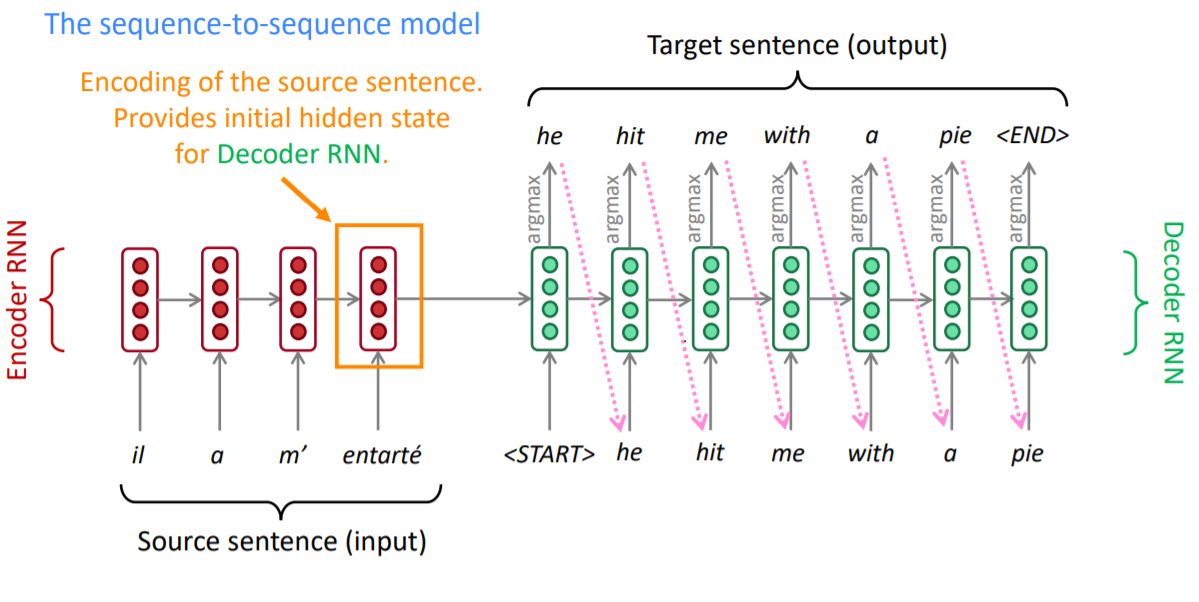

## Encoder

We will start with a single-layer unidirectional GRU. You are free to try bidirectional and stack more layers, but otherwise you do not need to write any code for the encoder (but as always, read carefully to make sure you understand it).

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.):
    """
    Inputs: 
      - `input_size`: an int representing the RNN input size.
      - `hidden_size`: an int representing the RNN hidden size.
      - `dropout`: a float representing the dropout rate during training. Note
          that for 1-layer RNN this has no effect since dropout only applies to
          outputs of intermediate layers.
    """
    super(Encoder, self).__init__()
    self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True,
                      dropout=dropout, bidirectional=False)

  def forward(self, inputs, lengths):
    """
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of source
          sentences.
      - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence
          lengths of `inputs`.

    Returns:
      - `outputs`: a 3d-tensor of shape
        (batch_size, max_seq_length, hidden_size).
      - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).
      Hint: `outputs` and `finals` are both standard GRU outputs. Check:
      https://pytorch.org/docs/stable/nn.html#gru
    """
    packed = pack_padded_sequence(inputs, lengths.cpu(), batch_first=True,
                                  enforce_sorted=False)
    outputs, finals = self.rnn(packed)
    outputs, _ = pad_packed_sequence(outputs, batch_first=True,
                                     total_length=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    return outputs, finals

## Decoder

The decoder is a conditional GRU. Rather than starting with an empty state like the encoder, its initial hidden state results from a projection of the encoder final vector. 

In [ ]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(Decoder, self).__init__()

    ### Your code here!

  def forward_step(self, prev_embed, hidden):
    """Perform a single decoder step (1 word)."""

    ### Your code here!

    return output, hidden, pre_output
    
  def forward(self, inputs, encoder_finals, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.

    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `hidden`: a 3d-tensor of shape
          (num_layers, batch_size, hidden_size) representing the final hidden
          state for each element in the batch.
      - `pre_output_vectors`: a 3-d tensor of shape
          (batch_size, max_len, hidden_size) representing the raw decoder
          outputs (before mapping to a `trg_vocab_size`-dim vector).
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    ### Your code here!

    return hidden, pre_output_vectors

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    ### Your code here!
    return decoder_init_hiddens

## Encoder-Decoder

Here we define the high level encoder-decoder class to wrap up sub-models, including encoder, decoder, generator, and src/trg embeddings. You do not need to write any code for this module.

In [ ]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `Decoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    del encoder_hiddens
    return self.decode(encoder_finals, trg_ids[:, :-1])

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)

Once you have implemented your model, run this cell to train and evaluate your model. Note that the hyperparameters chosen here are not necessarily optimal—you may want to adjust them to improve performance.

In [ ]:
# Hyperparameters for contructing the encoder-decoder model.

embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256  # RNN hidden size.
dropout = 0.2

pure_seq2seq = EncoderDecoder(
  encoder=Encoder(embed_size, hidden_size, dropout=dropout),
  decoder=Decoder(embed_size, hidden_size, dropout=dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

def train(model, num_epochs, learning_rate, train_data_loader, val_data_loader, task, print_every):

# Start training. The returned `dev_ppls` is a list of dev perplexity for each
# epoch.
pure_dev_ppls = train(pure_seq2seq, num_epochs=10, learning_rate=1e-3,
                      train_data_loader=mt_train_data_loader,
                      val_data_loader=mt_val_data_loader,
                      task="seq2seq", print_every=100)

plot_perplexity(pure_dev_ppls)

Run the following cell to visualize some of the translations produced by your model.

In [ ]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(mt_val_set, batch_size=1, num_workers=1,
                                      shuffle=False)

print_examples(pure_seq2seq, example_data_loader)

For translation, BLEU score gives a better measure of performance than perplexity. Run this cell to compute your model's BLEU score on a test dataset.

In [ ]:
test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling=1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)

print(np.mean(compute_BLEU(pure_seq2seq, test_data_loader)))  # BLEU: 5.8

### Attention-based Decoder (for 6.864 students only)


In [ ]:
class AttentionDecoder(nn.Module):
  """An attention-based RNN decoder."""

  def __init__(self, input_size, hidden_size, attention, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(AttentionDecoder, self).__init__()

    ### Your code here!

  def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key,
                   hidden):
    """Perform a single decoder step (1 word)"""

    ### Your code here!

    return output, hidden, pre_output
    
  def forward(self, inputs, encoder_hiddens, encoder_finals,  src_mask,
              trg_mask, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.
    
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_hiddens`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the encoder
          outputs for each decoding step to attend to. 
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `src_mask`: a 3d-tensor of shape (batch_size, 1, max_seq_length)
          representing the mask for source sentences.
      - `trg_mask`: a 3d-tensor of shape (batch_size, 1, max_seq_length)
          representing the mask for target sentences.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `hidden`: a 3d-tensor of shape
          (num_layers, batch_size, hidden_size) representing the final hidden
          state for each element in the batch.
      - `pre_output_vectors`: a 3-d tensor of shape
          (batch_size, max_len, hidden_size) representing the raw decoder
          outputs (before mapping to a `trg_vocab_size`-dim vector).
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = trg_mask.size(-1)

    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    ### Your code here!

    return hidden, pre_output_vectors

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    ### Your code here!
    return decoder_init_hiddens

## Attention-based Encoder-Decoder (for 6.864 students only)

In [ ]:
class EncoderAttentionDecoder(nn.Module):
  """A Encoder-Decoder architecture with attention.
  """
  def __init__(self, encoder, decoder, src_embed , trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `AttentionDecoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderAttentionDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and tar get sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    ### Your code here!

  def encode(self, src_ids, src_lengths):
    ### Your code here!

  def decode(self, encoder_hiddens, encoder_finals, src_mask, trg_ids,
             trg_mask, decoder_hidden=None):
    ### Your code here!

### Attention (for 6.864 students only)                  

Attention layer plays a key role in seq2seq models. It allows for capturing the dependencies without the distance constraints in the input or output sequences. In this lab, your goal is to implement the Bahdanau attention mechanism. You may find this [explanation of Bahdanau attention](https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a#:~:text=Bahdanau%20attention%20mechanism) helpful.

In [ ]:
class BahdanauAttention(nn.Module):
  """Implements Bahdanau (MLP) attention."""

  def __init__(self, hidden_size, key_size=None, query_size=None):
    super(BahdanauAttention, self).__init__()

    ### Your code here!

    # To store attention scores.
    self.alphas = None
        
  def forward(self, query=None, proj_key=None, value=None, mask=None):
    assert mask is not None, "mask is required"

    ### Your code here!
    
    return context, alphas

Once you have implemented your model, run this cell to train and evaluate it.

In [ ]:
attn_seq2seq = EncoderAttentionDecoder(
  encoder=Encoder(embed_size, hidden_size, dropout=dropout),
  decoder=AttentionDecoder(embed_size, hidden_size,
                  attention=BahdanauAttention(hidden_size), dropout=dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

attn_dev_ppls = train(attn_seq2seq, num_epochs=10, learning_rate=1e-3,
                      train_data_loader=mt_train_data_loader,
                      val_data_loader=mt_val_data_loader,
                      task="seq2seq", print_every=100)

plot_perplexity(attn_dev_ppls)

Run the following cell to visualize some of the translations produced by your model.

In [ ]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(mt_val_set, batch_size=1, num_workers=1,
                                      shuffle=False)

print_examples(attn_seq2seq, example_data_loader)

For translation, BLEU score gives a better measure of performance than perplexity. Run this cell to compute your model's BLEU score on a test dataset.

In [ ]:
test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling=1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)

print(np.mean(compute_BLEU(attn_seq2seq, test_data_loader)))  # BLEU: 14.9